In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt




In [2]:
data = pd.read_csv('BITRE_Fatality-Table 1.csv')
data.head()

/var/folders/3l/xh28kn0j7_7d5hh7fgz188940000gn/T/ipykernel_2159/1511047806.py:1: DtypeWarning: Columns (10,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('BITRE_Fatality-Table 1.csv')


,Crash ID,State,Month,Year,Dayweek,Time,Crash Type,Bus Involvement,Heavy Rigid Truck Involvement,Articulated Truck Involvement,...,Age,National Remoteness Areas,SA4 Name 2021,National LGA Name 2021,National Road Type,Christmas Period,Easter Period,Age Group,Day of week,Time of day
0,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,19,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
1,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,9,NaN,NaN,NaN,NaN,No,No,0_to_16,Weekday,Night
2,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,21,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
3,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,45,NaN,NaN,NaN,NaN,No,No,40_to_64,Weekday,Night
4,20243023,Qld,4,2024,Friday,01:00,Single,No,No,No,...,24,Outer Regional Australia,Cairns,Cairns,Local Road,No,No,17_to_25,Weekday,Night


01:10:28 - cmdstanpy - INFO - Chain [1] start processing
01:10:28 - cmdstanpy - INFO - Chain [1] done processing
01:10:28 - cmdstanpy - INFO - Chain [1] start processing
01:10:29 - cmdstanpy - INFO - Chain [1] done processing


Evaluation Metrics for the Test Period (2023):
Day - MAE: 13.84, MSE: 269.03, MAPE: 19.60%
Night - MAE: 6.82, MSE: 68.66, MAPE: 16.46%


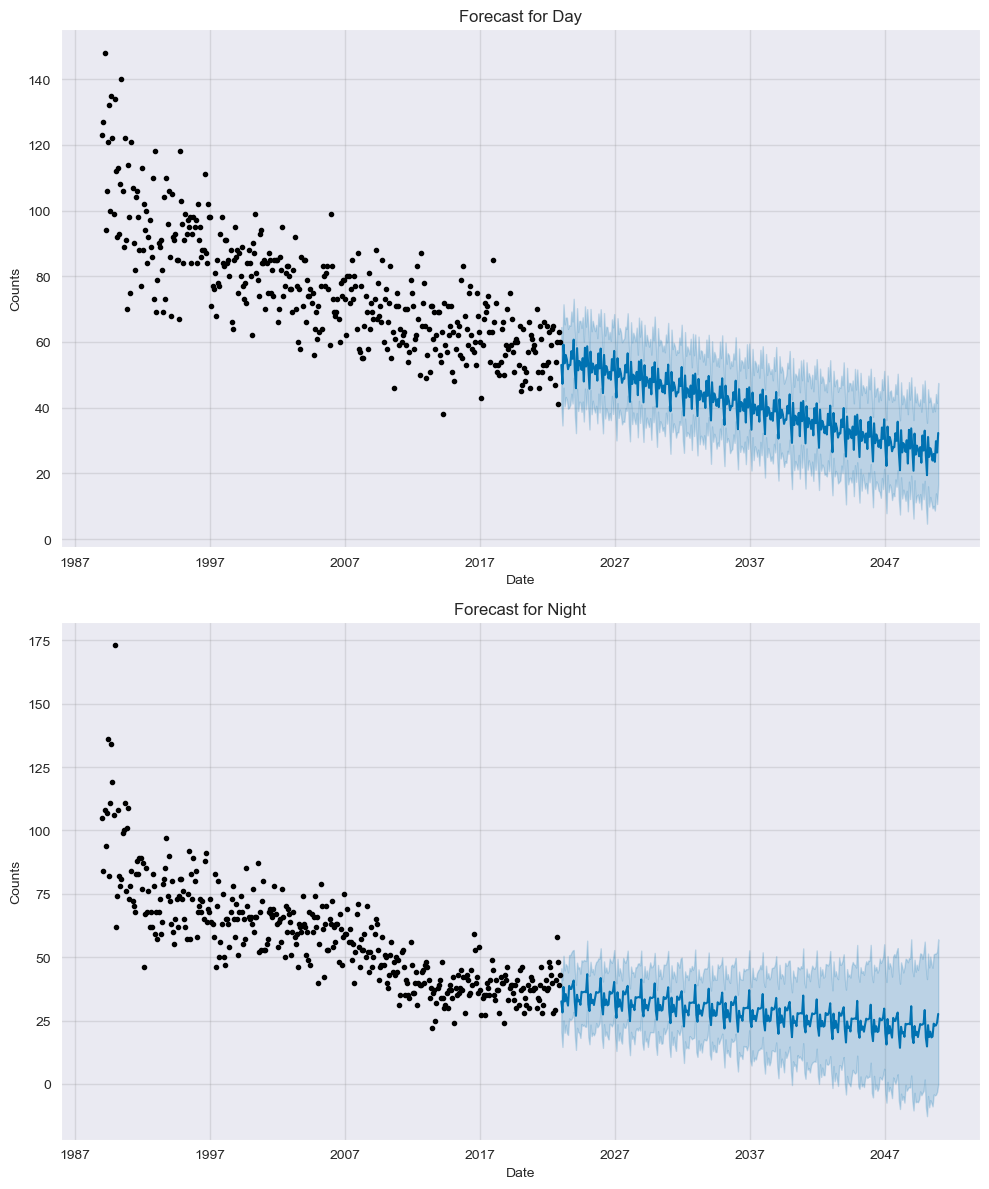

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Load the data

# Convert the 'Year' and 'Month' columns to a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Filter data up to 2022 for training and 2023 for testing
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Aggregate the number of occurrences of each 'Time of day' per month for training data
time_of_day_counts = train_data.groupby(['Date', 'Time of day']).size().reset_index(name='Counts')

# Prepare the data for Prophet
time_of_day_models = {}
forecasts = {}
for time in time_of_day_counts['Time of day'].unique():
    time_data = time_of_day_counts[time_of_day_counts['Time of day'] == time]
    time_data = time_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})
    
    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(time_data)
    time_of_day_models[time] = model
    
    # Create a dataframe for future dates including 2023 (test period) and beyond
    future_dates = pd.date_range(start='2023-01-01', end='2050-12-31', freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    
    # Predict future values
    forecast = model.predict(future)
    forecasts[time] = forecast

# Calculate and print evaluation metrics for the test period (2023)
print("Evaluation Metrics for the Test Period (2023):")
for time, forecast in forecasts.items():
    # Filter forecast for 2023
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]
    
    # Filter actual counts for 2023
    actual_counts_2023 = test_data[test_data['Time of day'] == time].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})
    
    # Ensure the forecast and actual data are aligned
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])
    
    print(f"{time} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%")

# Plot the forecasts
fig, axes = plt.subplots(nrows=len(forecasts), ncols=1, figsize=(10, 6*len(forecasts)))

for ax, (time, forecast) in zip(axes, forecasts.items()):
    model = time_of_day_models[time]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    ax.set_title(f'Forecast for {time}')

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot
fig.savefig('time_of_day_forecast.png')


01:46:03 - cmdstanpy - INFO - Chain [1] start processing
01:46:03 - cmdstanpy - INFO - Chain [1] done processing
01:46:04 - cmdstanpy - INFO - Chain [1] start processing
01:46:04 - cmdstanpy - INFO - Chain [1] done processing


Evaluation Metrics for the Test Period (2023):
Day - MAE: 10.69, MSE: 164.46, MAPE: 15.50%
Night - MAE: 5.64, MSE: 45.78, MAPE: 14.00%


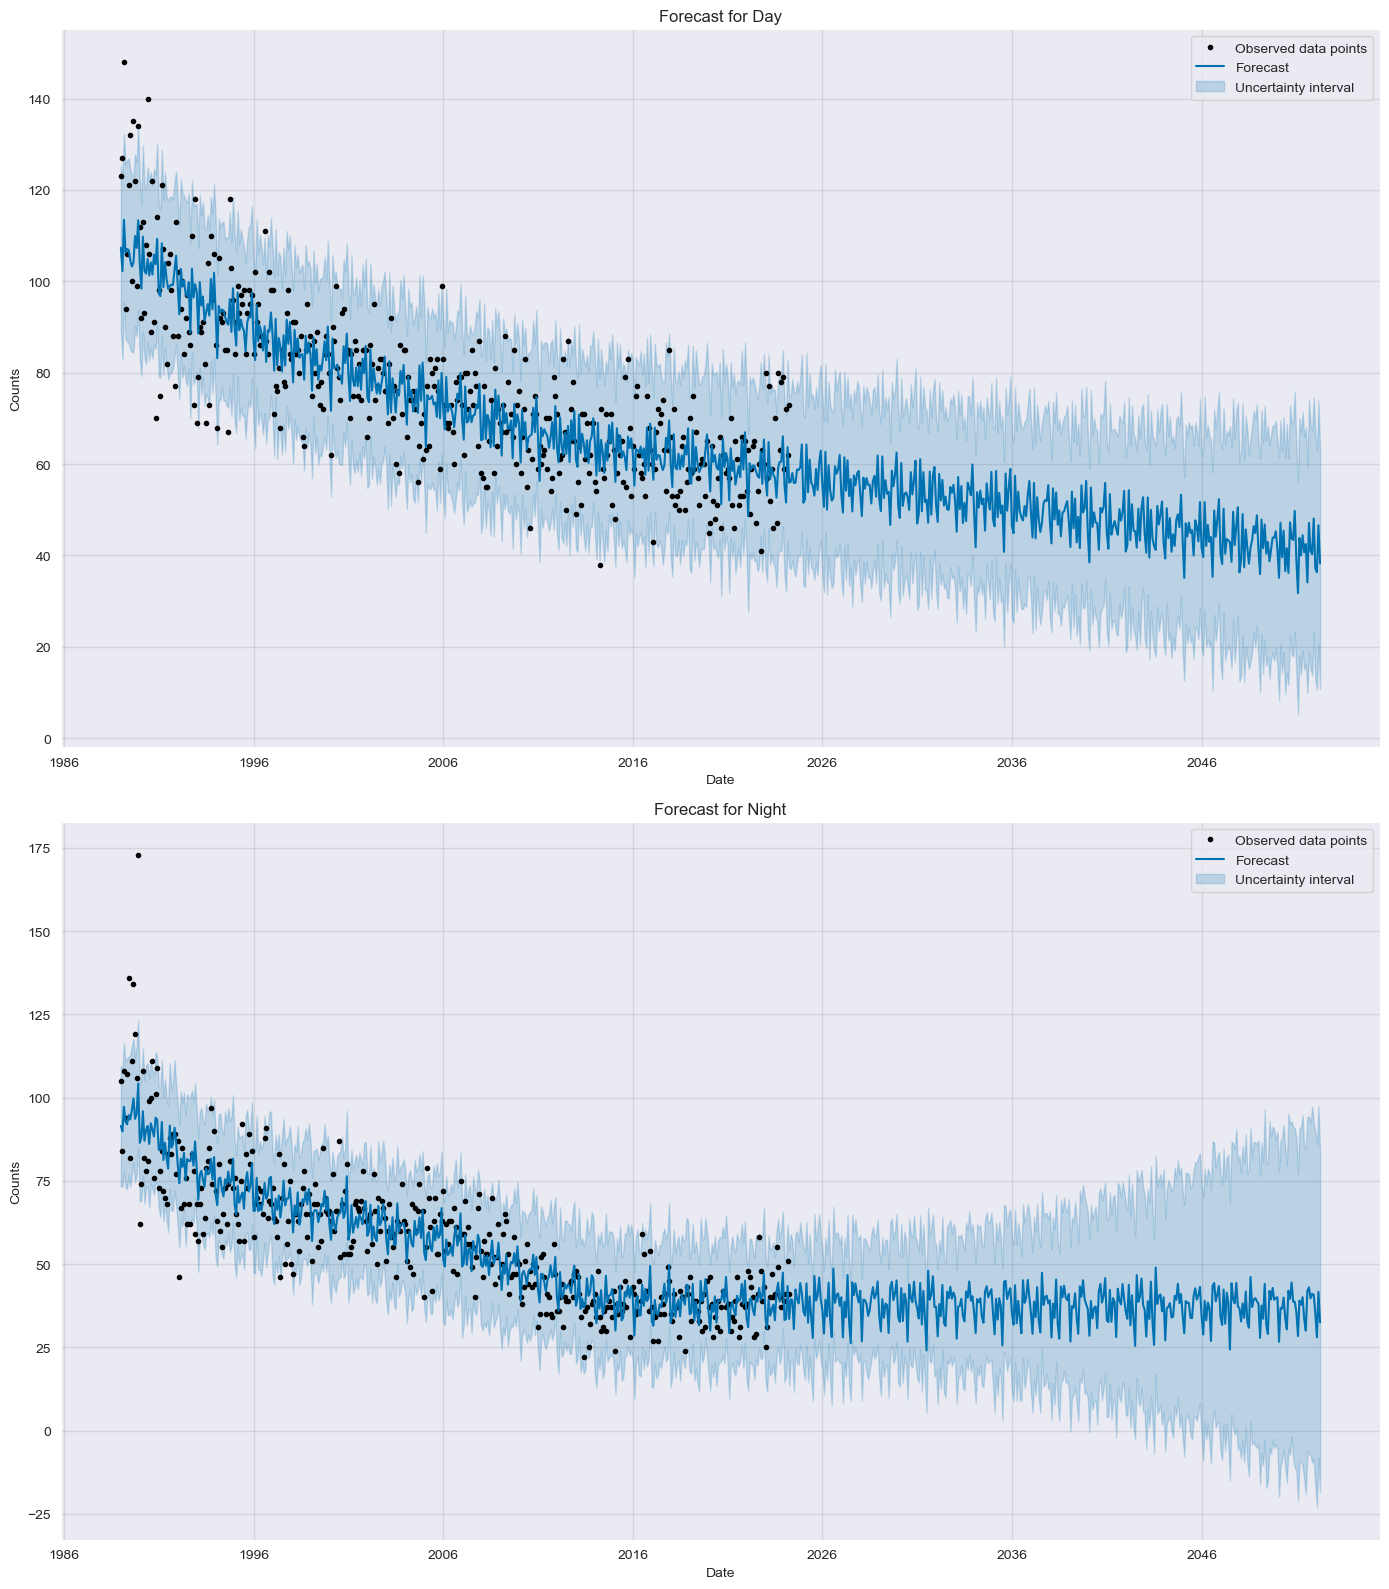

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100



# Convert the 'Year' and 'Month' columns to a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Filter data up to 2022 for training and 2023 for testing
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Aggregate the number of occurrences of each 'Time of day' per month for training data
time_of_day_counts = data.groupby(['Date', 'Time of day']).size().reset_index(name='Counts')

# Prepare the data for Prophet
time_of_day_models = {}
forecasts = {}
for time in time_of_day_counts['Time of day'].unique():
    time_data = time_of_day_counts[time_of_day_counts['Time of day'] == time]
    time_data = time_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})
    
    # Initialize and fit the Prophet model
    model = Prophet(interval_width=0.95,
        yearly_seasonality=True,
        daily_seasonality=True,
        weekly_seasonality=True)
    model.fit(time_data)
    time_of_day_models[time] = model
    
    # Create a dataframe for future dates including 2023 (test period) and beyond
    future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')
    
    # Predict future values
    forecast = model.predict(future_dates)
    forecasts[time] = forecast

# Calculate and print evaluation metrics for the test period (2023)
print("Evaluation Metrics for the Test Period (2023):")
for time, forecast in forecasts.items():
    # Filter forecast for 2023
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]
    
    # Filter actual counts for 2023
    actual_counts_2023 = test_data[test_data['Time of day'] == time].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})
    
    # Ensure the forecast and actual data are aligned
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])
    
    print(f"{time} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%")

# Plot the forecasts
fig, axes = plt.subplots(nrows=len(forecasts), ncols=1, figsize=(14, 8*len(forecasts)))

for ax, (time, forecast) in zip(axes, forecasts.items()):
    model = time_of_day_models[time]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # Plot training data
   # train_time_data = time_of_day_counts[time_of_day_counts['Time of day'] == time]
    #ax.scatter(train_time_data['Date'], train_time_data['Counts'], color='blue', s=10, label='Training Data')
    
    # Plot test data
   # test_time_data = test_data[test_data['Time of day'] == time].groupby('Date').size().reset_index(name='Counts')
    #ax.scatter(test_time_data['Date'], test_time_data['Counts'], color='red', s=10, label='Test Data')
    
    ax.legend()
    ax.set_title(f'Forecast for {time}')

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot
